## Imports

In [135]:
import pandas as pd
import re
import timeit
import numpy as np
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
import sklearn.metrics as sm
from sklearn.ensemble import IsolationForest
import plotly.express as px
import numpy as np
import warnings
import datetime
import xgboost as xgb
import math
import joblib
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

#Imports TFG Original
from prettytable import PrettyTable
from os import listdir
from os.path import isfile, join
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import accuracy_score , mean_squared_error
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from yellowbrick.model_selection import FeatureImportances
from sklearn.linear_model import LinearRegression



## Funció Alineament de Dades

In [136]:
def alignSeries(serie, lag):
    minutesRow = 30
    posToMove = int(lag / minutesRow)  
    outputSerie = serie['data'].to_numpy()
    size = len(outputSerie)
    outputSerie = np.pad(outputSerie, (posToMove,0), 'constant', constant_values=(0))
    outputSerie = outputSerie[:size]
    return outputSerie

## Carregar Dades

In [137]:
def prepareDFMod(df, col):
    output = df[[col]]
    output.rename(columns={col:'data'}, inplace=True)
    return output
    

In [138]:
# Carregar dades pluja
def loadDataPrecipitacions():
    precipitacions = pd.read_excel("finalsDF/DF_SMC.xlsx", index_col=0)
    return precipitacions

In [139]:
# Carregar dades Alt Ter
def loadDataAltTer(nom, altTer):
    
    altTer = prepareDFMod(altTer, nom)
    
    return altTer

In [140]:
# Carregar dades Baix Ter
def loadDataBaixTer(nom, baixTer):
    
    baixTer = prepareDFMod(baixTer, nom)

    return baixTer

In [141]:
#Carregar dades precipitacions Alt Ter:
def loadDataPrecipitacions(nom, precipitacions):
    
    #Carregar dades
    precipitacions = prepareDFMod(precipitacions, nom)
    
    #Moving Average
    precipitacions['data'] = precipitacions['data'].rolling(window=5).mean()
    precipitacions['data'] = precipitacions['data'].rolling(window=5).mean()
    
    return precipitacions

In [142]:
altTer = pd.read_excel("Dataframes/df_imputedAltTerKNN.xlsx", index_col=0)
baixTer = pd.read_excel("Dataframes/df_imputedBaixTerKNN.xlsx", index_col=0)
precipitacions = pd.read_csv("finalsDF/DF_SMC.csv", index_col=0)

# Alineament del DataFrame amb Referencia (Alt Ter)

In [143]:
idx = pd.date_range("2009-01-01", periods=210386, freq="30T")

In [144]:
ts = pd.Series(range(len(idx)), index=range(len(idx)))

In [145]:
#Carregar Dada Referencia Alt Ter (Masies)

masies = loadDataAltTer("L08116-72-00002", altTer)

#Carregar Dades Comparatives

#Alinear Ripoll
ripoll = loadDataAltTer("L17147-72-00005", altTer)
ripoll = alignSeries(ripoll, 150)

#Alinear Sant Joan
santJoan = loadDataAltTer("L17167-72-00001", altTer)
santJoan = alignSeries(santJoan, 180)

#Alinear DG
DG = loadDataPrecipitacions("DG", precipitacions)
DG = alignSeries(DG, 270)

#Alinear CG 
CG = loadDataPrecipitacions("CG", precipitacions)
CG = alignSeries(CG, 300)

#Alinear CI
CI = loadDataPrecipitacions("CI", precipitacions)
CI = alignSeries(CI, 150)

#Alinear V4
V4 = loadDataPrecipitacions("V4", precipitacions)
V4 = alignSeries(V4, 180)

#Alinear CC
CC = loadDataPrecipitacions("CC", precipitacions)
CC = alignSeries(CC, 195)

#Alinear CY
CY = loadDataPrecipitacions("CY", precipitacions)
CY = alignSeries(CY, 240)

#Alinear VN
VN = loadDataPrecipitacions("VN", precipitacions)
VN = alignSeries(VN, 300)

#Alinear WS
WS = loadDataPrecipitacions("WS", precipitacions)
WS = alignSeries(WS, 300)

#Alinear V3

V3 = loadDataPrecipitacions("V3", precipitacions)
V3 = alignSeries(V3, 210)

#Z4_ZC

In [146]:
#Creem el DataFrame amb les dades alineades i el guardem 
dfAlt = pd.DataFrame(index=range(len(idx)))
dfAlt["L17147-72-00005"] = pd.Series(ripoll.tolist())
dfAlt["L17167-72-00001"] = pd.Series(santJoan.tolist())
dfAlt['DG'] = pd.Series(DG.tolist())
dfAlt['CG'] = pd.Series(CG.tolist())
dfAlt['CI'] = pd.Series(CI.tolist())
dfAlt['V4'] = pd.Series(V4.tolist())
dfAlt['CC'] = pd.Series(CC.tolist())
dfAlt['CY'] = pd.Series(CY.tolist())
dfAlt['VN'] = pd.Series(VN.tolist())
dfAlt['WS'] = pd.Series(WS.tolist())
dfAlt['V3'] = pd.Series(WS.tolist())



In [147]:
#Assignem les hores al index
dfAlt['datetime'] = pd.date_range("2009-01-01", periods=210386, freq="30T")
dfAlt.set_index('datetime', drop=True, inplace=True)

#Eliminem del top el maxim de posicions que hem alineat (en aquest cas 300)

minutesRow = 30
lag = 300
posToMove = int(lag / minutesRow)
dfAlt.drop(dfAlt.head(posToMove).index, inplace=True)
dfAlt.drop(dfAlt.tail(1).index, inplace=True)
dfAlt.fillna(0, inplace=True)
dfAltX = dfAlt

In [148]:
#Eliminem les mateixes columnes del 
masies = loadDataAltTer("L08116-72-00002", altTer)
minutesRow = 30
lag = 300
posToMove = int(lag / minutesRow)
masies.drop(masies.head(posToMove).index, inplace=True)
masies.rename(columns={'data':'L08116-72-00002'}, inplace=True)
dfAltY = masies
dfAltX['L08116-72-00002'] = dfAltY['L08116-72-00002']
dfAltX.fillna(0, inplace=True)

In [150]:
#Guardem el matrix de X y el array de y en un csv

dfAltX.to_csv('dfAltX.csv')
dfAltY.to_csv('dfAltY.csv')

# Random Forest (Alt Ter)

In [151]:
#Carregar del csv
Df_AltX = pd.read_csv('dfAltX.csv')
Df_Alty = pd.read_csv('dfAltY.csv')

In [152]:
Df_AltX.set_index('datetime', drop=True, inplace=True)
Df_Alty.set_index('DATA', drop=True, inplace=True)

In [153]:
df_results_altTer = pd.DataFrame(columns = ["Method", "Best_Params", "Features","Feature_Importance", "Score","RMSE_Score","Prediccio_Hores"])

Iteració:  1
CPU times: total: 8.05 s
Wall time: 1min 5s


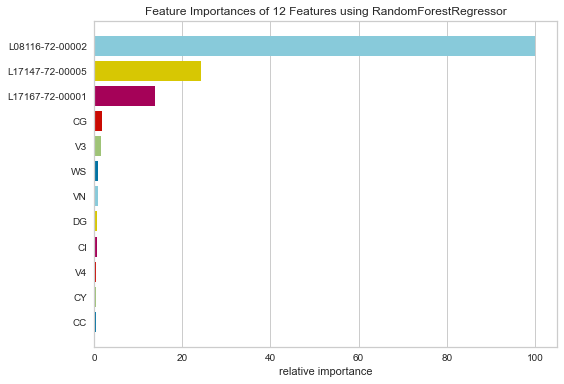

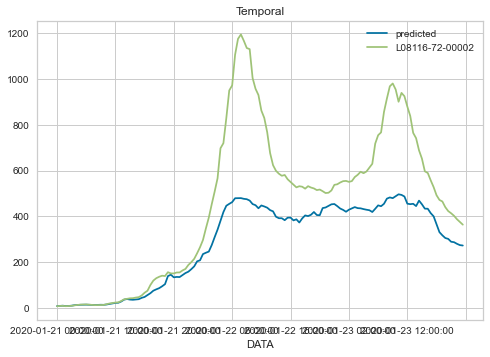

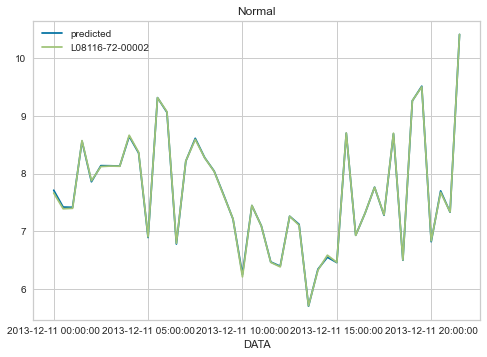

Iteració:  2
CPU times: total: 15.5 s
Wall time: 2min 21s


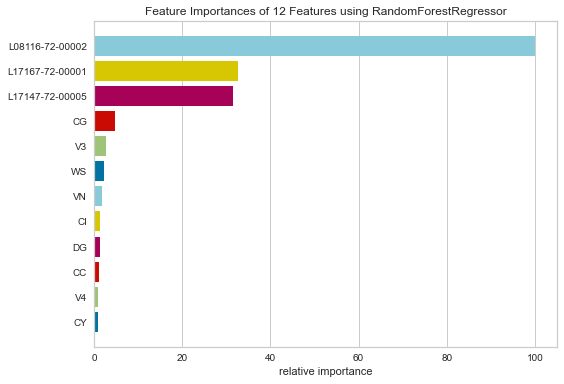

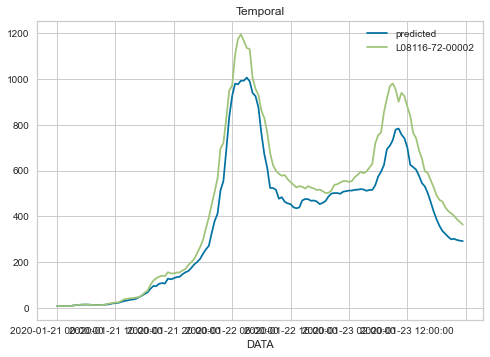

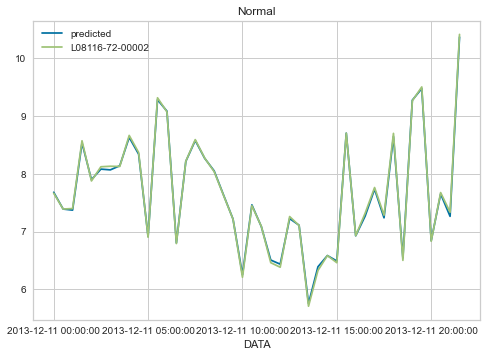

Iteració:  3
CPU times: total: 58 s
Wall time: 4min 36s


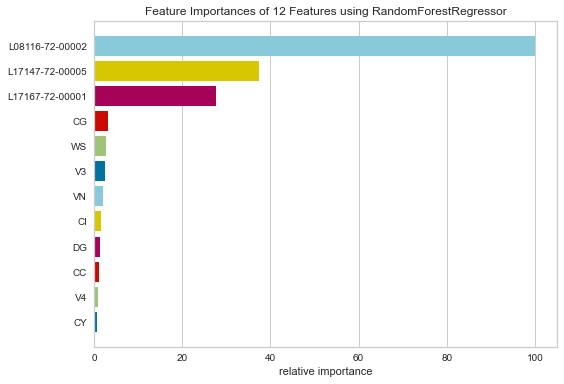

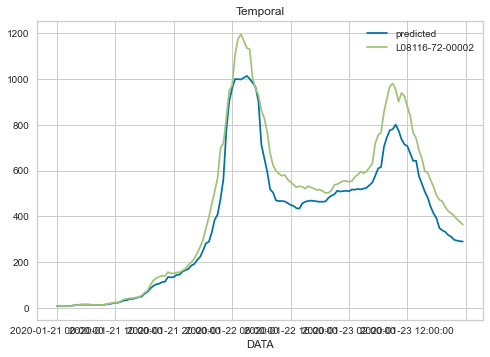

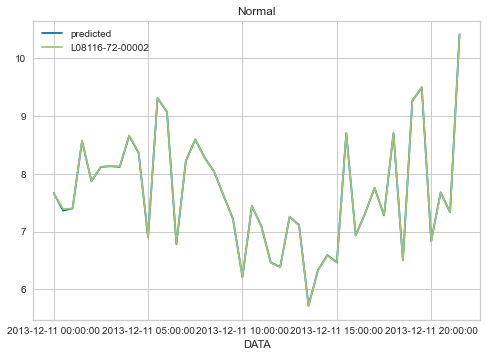

Time:  0:08:42.011220


In [154]:
start = timeit.default_timer()

tscv = TimeSeriesSplit(n_splits=3)
param_search = { 
    'n_estimators': [50,100, 200], # Nombre de arbres
    'max_features': [1, 'sqrt', 'log2'], # Maxim features
    'max_depth' : [8,10,25,None] # Profunditat dels arbres
}

iteracio = 0
for train_index, test_index in tscv.split(Df_AltX):
    iteracio += 1
    Df_AltX_train, Df_AltX_test = Df_AltX.values[train_index], Df_AltX.values[test_index]
    Df_Alty_train, Df_Alty_test = Df_Alty.values.ravel()[train_index], Df_Alty.values.ravel()[test_index]

    model = RandomForestRegressor()
    tscv = TimeSeriesSplit(n_splits=5)
    gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, n_jobs=-1)
    print("Iteració: ", iteracio)
    %time gsearchfited = gsearch.fit(Df_AltX_train, Df_Alty_train)
        
    bestParams = gsearchfited.best_params_
    score = gsearchfited.score(Df_AltX_test, Df_Alty_test)
    FeatureImportance = gsearchfited.best_estimator_.feature_importances_
    
    predicty = gsearchfited.best_estimator_.predict(Df_AltX_test)
    rmseScore = mean_squared_error(Df_Alty_test, predicty, squared=False)
    
    nameh = Df_AltX.columns[0]
    hores = "1 day"
    
    new_row = {'Method':'Random Forest','Best_Params':bestParams, 'Features':Df_AltX.columns, 'Feature_Importance':FeatureImportance, 'Score':score,'RMSE_Score':rmseScore,"Prediccio_Hores":hores}
    df_results_altTer = df_results_altTer.append(new_row, ignore_index=True)
    
    joblib.dump(gsearchfited.best_estimator_, 'resultsDf/pickle/partAlta/RandomForest_'+str(df_results_altTer.index[-1])+'.pkl', compress = 1)

    viz = FeatureImportances(gsearchfited.best_estimator_)
    viz.fit(Df_AltX, Df_Alty)
    viz.show()
    
    plotYtest = Df_Alty["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotYtest2 = Df_Alty["2013-12-10 5:00:00":"2013-12-11 21:30:00"]
    
    plotXtestp = Df_AltX["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotXtest2p = Df_AltX["2013-12-10 5:00:00":"2013-12-11 21:30:00"]
    
    plotXtestr = gsearchfited.best_estimator_.predict(plotXtestp.values)
    plotXtest2r = gsearchfited.best_estimator_.predict(plotXtest2p.values)
    
    plotYtest.insert(0, 'predicted', plotXtestr, allow_duplicates=True)
    plotYtest2.insert(0, 'predicted', plotXtest2r, allow_duplicates=True)

    plotYtest.plot(title="Temporal")
    plotYtest2.plot(title="Normal")
    plt.show()

    
stop = timeit.default_timer()
print("Time: ", str(datetime.timedelta(seconds=(stop-start))))

In [155]:
df_results_altTer

,Method,Best_Params,Features,Feature_Importance,Score,RMSE_Score,Prediccio_Hores
0,Random Forest,"{'max_depth': None, 'max_features': 'sqrt', 'n...","Index(['L17147-72-00005', 'L17167-72-00001', '...","[0.16555096610692582, 0.0948182617497637, 0.00...",0.875799,9.204491,1 day
1,Random Forest,"{'max_depth': 25, 'max_features': 'sqrt', 'n_e...","Index(['L17147-72-00005', 'L17167-72-00001', '...","[0.17428228536307852, 0.17963026660138692, 0.0...",0.970233,2.562699,1 day
2,Random Forest,"{'max_depth': None, 'max_features': 'log2', 'n...","Index(['L17147-72-00005', 'L17167-72-00001', '...","[0.20646414875922703, 0.1527808821577307, 0.00...",0.954836,8.795338,1 day


# XGBoost (Alt Ter)

In [156]:
#Carregar del csv
Df_AltX = pd.read_csv('dfAltX.csv')
Df_Alty = pd.read_csv('dfAltY.csv')

In [157]:
Df_AltX.set_index('datetime', drop=True, inplace=True)
Df_Alty.set_index('DATA', drop=True, inplace=True)

Iteració:  1
[16:39:29] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


CPU times: total: 28.5 s
Wall time: 1min 7s


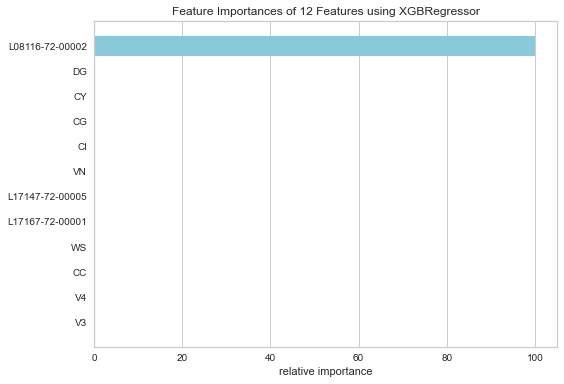

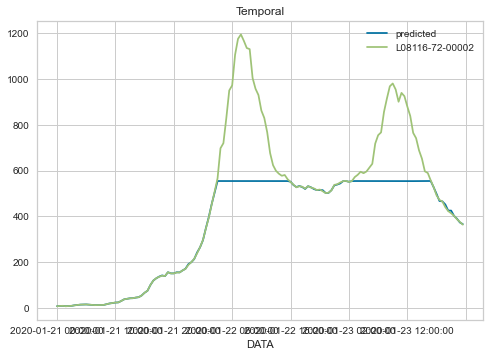

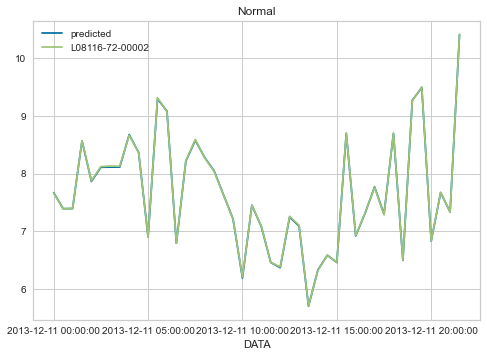

Iteració:  2
[16:41:57] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


CPU times: total: 1min 22s
Wall time: 2min 32s


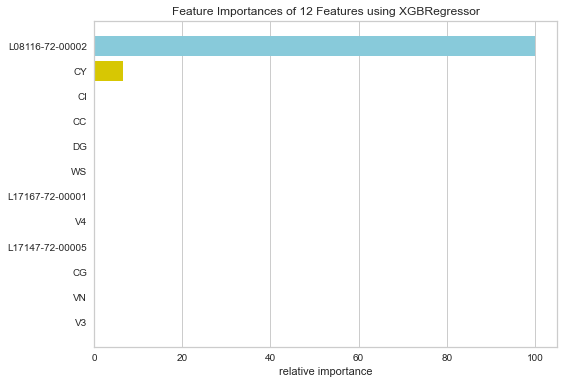

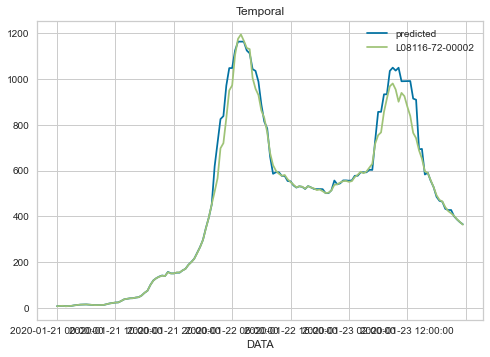

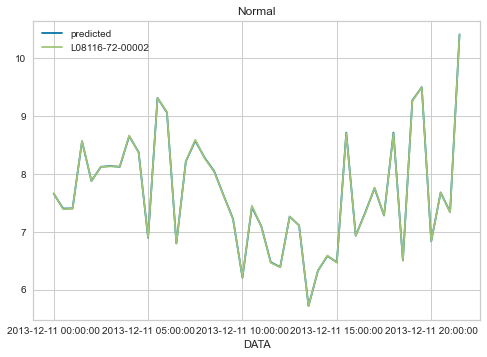

Iteració:  3
[16:45:49] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


CPU times: total: 1min 40s
Wall time: 3min 52s


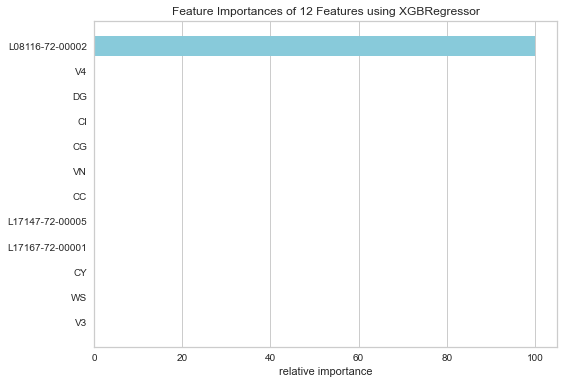

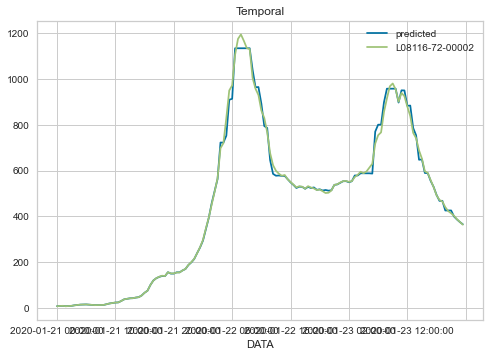

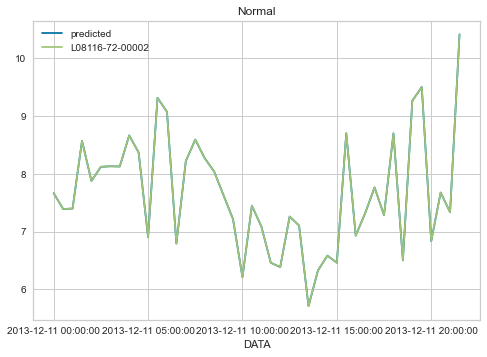

Time:  0:07:34.349835


In [158]:
start = timeit.default_timer()

tscv = TimeSeriesSplit(n_splits=3)
param_search = { 
    'n_estimators': [50,100, 200], # Nombre de arbres
    'max_features': [1, 'sqrt', 'log2'], # Maxim features
    'max_depth' : [8,10,25,None] # Profunditat dels arbres
}

iteracio = 0
for train_index, test_index in tscv.split(Df_AltX):
    iteracio += 1
    Df_AltX_train, Df_AltX_test = Df_AltX.values[train_index], Df_AltX.values[test_index]
    Df_Alty_train, Df_Alty_test = Df_Alty.values.ravel()[train_index], Df_Alty.values.ravel()[test_index]

    model = xgb.XGBRegressor()
    tscv = TimeSeriesSplit(n_splits=5)
    gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, n_jobs=-1)
    print("Iteració: ", iteracio)
    %time gsearchfited = gsearch.fit(Df_AltX_train, Df_Alty_train)
        
    bestParams = gsearchfited.best_params_
    score = gsearchfited.score(Df_AltX_test, Df_Alty_test)
    FeatureImportance = gsearchfited.best_estimator_.feature_importances_
    
    predicty = gsearchfited.best_estimator_.predict(Df_AltX_test)
    rmseScore = mean_squared_error(Df_Alty_test, predicty, squared=False)
    
    nameh = Df_AltX.columns[0]
    hores = "1 day"
    
    new_row = {'Method':'XGBoost','Best_Params':bestParams, 'Features':Df_AltX.columns, 'Feature_Importance':FeatureImportance, 'Score':score,'RMSE_Score':rmseScore,"Prediccio_Hores":hores}
    df_results_altTer = df_results_altTer.append(new_row, ignore_index=True)
    
    joblib.dump(gsearchfited.best_estimator_, 'resultsDf/pickle/partAlta/XGBoost_'+str(df_results_altTer.index[-1])+'.pkl', compress = 1)

    viz = FeatureImportances(gsearchfited.best_estimator_)
    viz.fit(Df_AltX, Df_Alty)
    viz.show()
    
    plotYtest = Df_Alty["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotYtest2 = Df_Alty["2013-12-10 5:00:00":"2013-12-11 21:30:00"]
    
    plotXtestp = Df_AltX["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotXtest2p = Df_AltX["2013-12-10 5:00:00":"2013-12-11 21:30:00"]
    
    plotXtestr = gsearchfited.best_estimator_.predict(plotXtestp.values)
    plotXtest2r = gsearchfited.best_estimator_.predict(plotXtest2p.values)
    
    plotYtest.insert(0, 'predicted', plotXtestr, allow_duplicates=True)
    plotYtest2.insert(0, 'predicted', plotXtest2r, allow_duplicates=True)

    plotYtest.plot(title="Temporal")
    plotYtest2.plot(title="Normal")
    plt.show()

    
stop = timeit.default_timer()
print("Time: ", str(datetime.timedelta(seconds=(stop-start))))

In [159]:
df_results_altTer

,Method,Best_Params,Features,Feature_Importance,Score,RMSE_Score,Prediccio_Hores
0,Random Forest,"{'max_depth': None, 'max_features': 'sqrt', 'n...","Index(['L17147-72-00005', 'L17167-72-00001', '...","[0.16555096610692582, 0.0948182617497637, 0.00...",0.875799,9.204491,1 day
1,Random Forest,"{'max_depth': 25, 'max_features': 'sqrt', 'n_e...","Index(['L17147-72-00005', 'L17167-72-00001', '...","[0.17428228536307852, 0.17963026660138692, 0.0...",0.970233,2.562699,1 day
2,Random Forest,"{'max_depth': None, 'max_features': 'log2', 'n...","Index(['L17147-72-00005', 'L17167-72-00001', '...","[0.20646414875922703, 0.1527808821577307, 0.00...",0.954836,8.795338,1 day
3,XGBoost,"{'max_depth': 8, 'max_features': 1, 'n_estimat...","Index(['L17147-72-00005', 'L17167-72-00001', '...","[1.1433498e-05, 9.153465e-06, 6.524661e-05, 2....",0.930524,6.884225,1 day
4,XGBoost,"{'max_depth': 10, 'max_features': 1, 'n_estima...","Index(['L17147-72-00005', 'L17167-72-00001', '...","[1.6611977e-05, 2.0152296e-05, 9.020477e-05, 1...",0.991847,1.341166,1 day
5,XGBoost,"{'max_depth': 25, 'max_features': 1, 'n_estima...","Index(['L17147-72-00005', 'L17167-72-00001', '...","[2.2550737e-05, 1.6985605e-05, 0.00013349889, ...",0.989582,4.224242,1 day


# ExtraTrees (Alt Ter)

In [160]:
#Carregar del csv
Df_AltX = pd.read_csv('dfAltX.csv')
Df_Alty = pd.read_csv('dfAltY.csv')

In [161]:
Df_AltX.set_index('datetime', drop=True, inplace=True)
Df_Alty.set_index('DATA', drop=True, inplace=True)

Iteració:  1
CPU times: total: 1.33 s
Wall time: 33 s


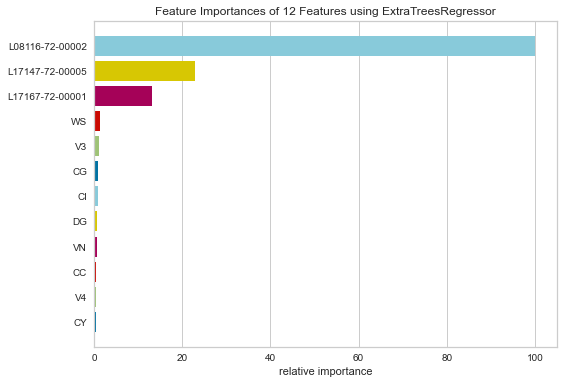

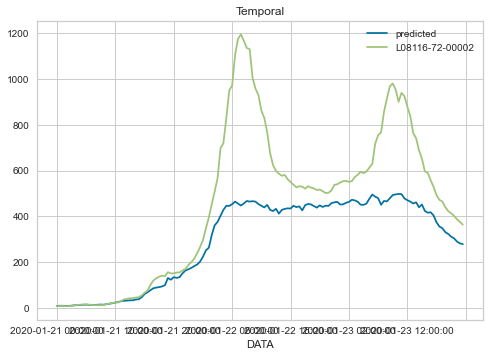

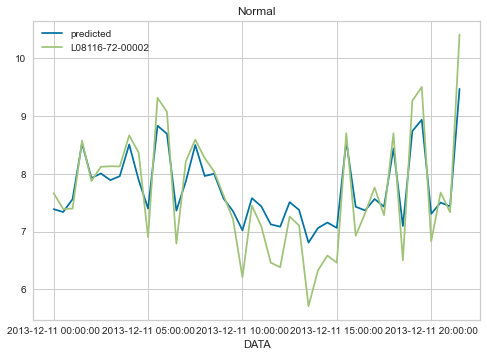

Iteració:  2
CPU times: total: 22.4 s
Wall time: 1min 33s


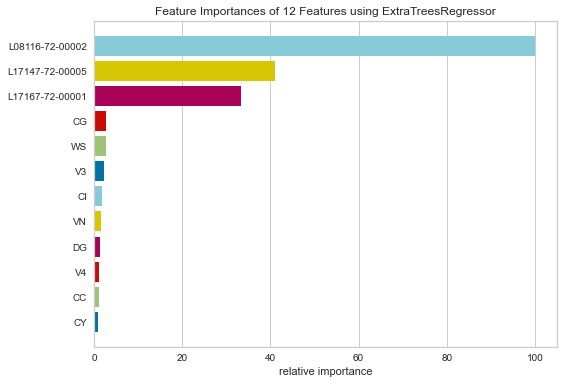

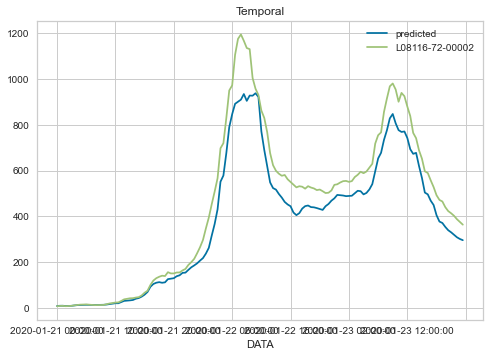

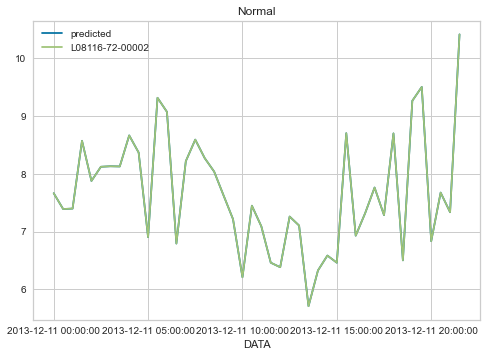

Iteració:  3
CPU times: total: 18 s
Wall time: 2min 48s


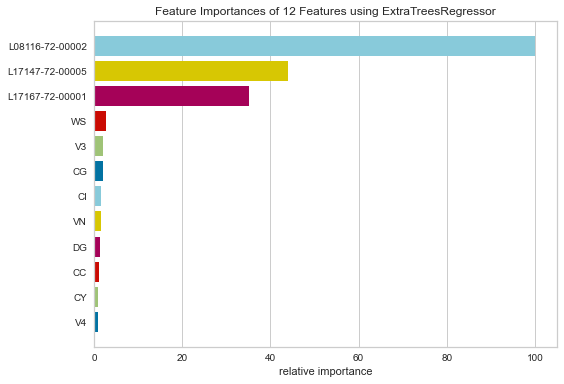

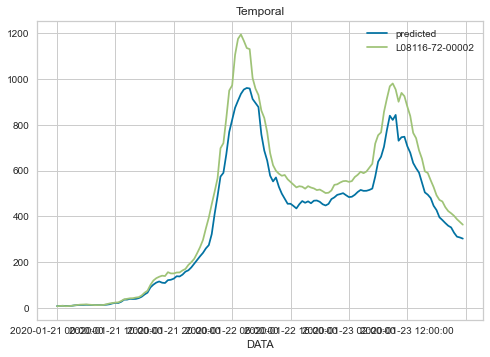

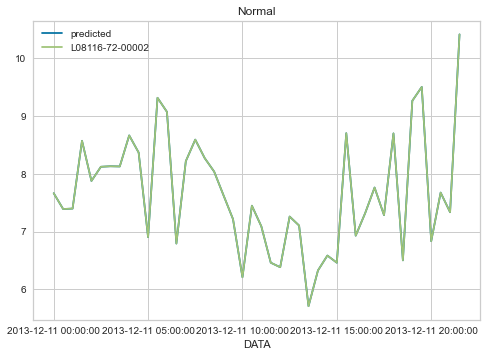

Time:  0:05:47.454509


In [162]:
start = timeit.default_timer()

tscv = TimeSeriesSplit(n_splits=3)
param_search = { 
    'n_estimators': [50,100, 200], # Nombre de arbres
    'max_features': [1, 'sqrt', 'log2'], # Maxim features
    'max_depth' : [8,10,25,None] # Profunditat dels arbres
}

iteracio = 0
for train_index, test_index in tscv.split(Df_AltX):
    iteracio += 1
    Df_AltX_train, Df_AltX_test = Df_AltX.values[train_index], Df_AltX.values[test_index]
    Df_Alty_train, Df_Alty_test = Df_Alty.values.ravel()[train_index], Df_Alty.values.ravel()[test_index]

    model = ExtraTreesRegressor()
    tscv = TimeSeriesSplit(n_splits=5)
    gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, n_jobs=-1)
    print("Iteració: ", iteracio)
    %time gsearchfited = gsearch.fit(Df_AltX_train, Df_Alty_train)
        
    bestParams = gsearchfited.best_params_
    score = gsearchfited.score(Df_AltX_test, Df_Alty_test)
    FeatureImportance = gsearchfited.best_estimator_.feature_importances_
    
    predicty = gsearchfited.best_estimator_.predict(Df_AltX_test)
    rmseScore = mean_squared_error(Df_Alty_test, predicty, squared=False)
    
    nameh = Df_AltX.columns[0]
    hores = "1 day"
    
    new_row = {'Method':'ExtraTrees','Best_Params':bestParams, 'Features':Df_AltX.columns, 'Feature_Importance':FeatureImportance, 'Score':score,'RMSE_Score':rmseScore,"Prediccio_Hores":hores}
    df_results_altTer = df_results_altTer.append(new_row, ignore_index=True)
    
    joblib.dump(gsearchfited.best_estimator_, 'resultsDf/pickle/partAlta/ExtraTrees_'+str(df_results_altTer.index[-1])+'.pkl', compress = 1)

    viz = FeatureImportances(gsearchfited.best_estimator_)
    viz.fit(Df_AltX, Df_Alty)
    viz.show()
    
    plotYtest = Df_Alty["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotYtest2 = Df_Alty["2013-12-10 5:00:00":"2013-12-11 21:30:00"]
    
    plotXtestp = Df_AltX["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotXtest2p = Df_AltX["2013-12-10 5:00:00":"2013-12-11 21:30:00"]
    
    plotXtestr = gsearchfited.best_estimator_.predict(plotXtestp.values)
    plotXtest2r = gsearchfited.best_estimator_.predict(plotXtest2p.values)
    
    plotYtest.insert(0, 'predicted', plotXtestr, allow_duplicates=True)
    plotYtest2.insert(0, 'predicted', plotXtest2r, allow_duplicates=True)

    plotYtest.plot(title="Temporal")
    plotYtest2.plot(title="Normal")
    plt.show()

    
stop = timeit.default_timer()
print("Time: ", str(datetime.timedelta(seconds=(stop-start))))

In [163]:
df_results_altTer

,Method,Best_Params,Features,Feature_Importance,Score,RMSE_Score,Prediccio_Hores
0,Random Forest,"{'max_depth': None, 'max_features': 'sqrt', 'n...","Index(['L17147-72-00005', 'L17167-72-00001', '...","[0.16555096610692582, 0.0948182617497637, 0.00...",0.875799,9.204491,1 day
1,Random Forest,"{'max_depth': 25, 'max_features': 'sqrt', 'n_e...","Index(['L17147-72-00005', 'L17167-72-00001', '...","[0.17428228536307852, 0.17963026660138692, 0.0...",0.970233,2.562699,1 day
2,Random Forest,"{'max_depth': None, 'max_features': 'log2', 'n...","Index(['L17147-72-00005', 'L17167-72-00001', '...","[0.20646414875922703, 0.1527808821577307, 0.00...",0.954836,8.795338,1 day
3,XGBoost,"{'max_depth': 8, 'max_features': 1, 'n_estimat...","Index(['L17147-72-00005', 'L17167-72-00001', '...","[1.1433498e-05, 9.153465e-06, 6.524661e-05, 2....",0.930524,6.884225,1 day
4,XGBoost,"{'max_depth': 10, 'max_features': 1, 'n_estima...","Index(['L17147-72-00005', 'L17167-72-00001', '...","[1.6611977e-05, 2.0152296e-05, 9.020477e-05, 1...",0.991847,1.341166,1 day
5,XGBoost,"{'max_depth': 25, 'max_features': 1, 'n_estima...","Index(['L17147-72-00005', 'L17167-72-00001', '...","[2.2550737e-05, 1.6985605e-05, 0.00013349889, ...",0.989582,4.224242,1 day
6,ExtraTrees,"{'max_depth': 25, 'max_features': 'log2', 'n_e...","Index(['L17147-72-00005', 'L17167-72-00001', '...","[0.15992447001227925, 0.09238869588040553, 0.0...",0.869405,9.438442,1 day
7,ExtraTrees,"{'max_depth': None, 'max_features': 'sqrt', 'n...","Index(['L17147-72-00005', 'L17167-72-00001', '...","[0.216055308432247, 0.17528561975768914, 0.007...",0.96684,2.704799,1 day
8,ExtraTrees,"{'max_depth': None, 'max_features': 'sqrt', 'n...","Index(['L17147-72-00005', 'L17167-72-00001', '...","[0.22649142241631182, 0.18129713167879047, 0.0...",0.955859,8.695177,1 day


# Linear Regression (Alt Ter)

In [164]:
#Carregar del csv
Df_AltX = pd.read_csv('dfAltX.csv')
Df_Alty = pd.read_csv('dfAltY.csv')

In [165]:
Df_AltX.set_index('datetime', drop=True, inplace=True)
Df_Alty.set_index('DATA', drop=True, inplace=True)

Iteració:  1
CPU times: total: 109 ms
Wall time: 86.4 ms


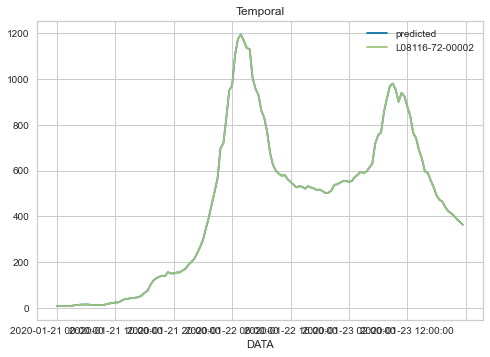

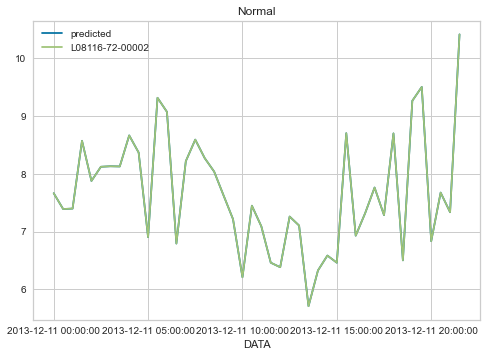

Iteració:  2
CPU times: total: 93.8 ms
Wall time: 17 ms


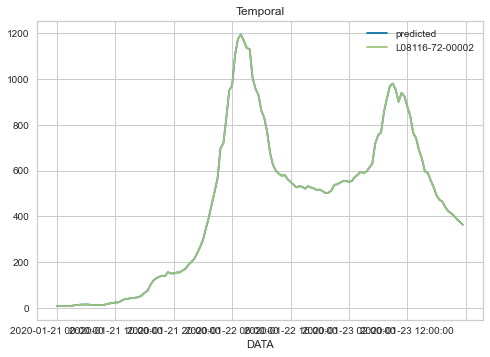

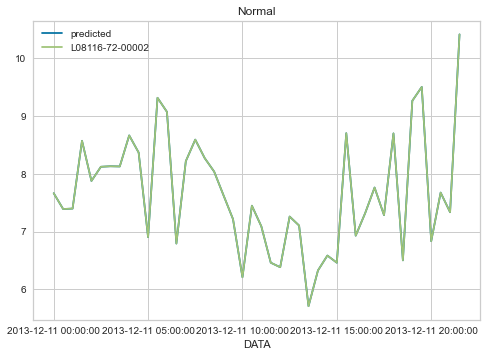

Iteració:  3
CPU times: total: 31.2 ms
Wall time: 30 ms


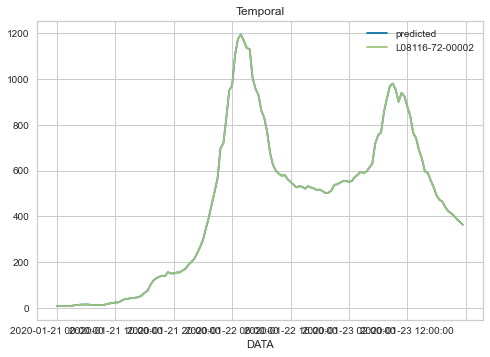

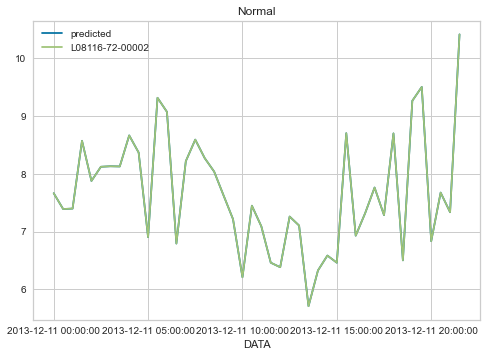

Time:  0:00:00.967398


In [166]:
start = timeit.default_timer()

tscv = TimeSeriesSplit(n_splits=3)
param_search = { 
    'n_estimators': [50,100, 200], # Nombre de arbres
    'max_features': [1, 'sqrt', 'log2'], # Maxim features
    'max_depth' : [8,10,25,None] # Profunditat dels arbres
}

iteracio = 0
for train_index, test_index in tscv.split(Df_AltX):
    iteracio += 1
    Df_AltX_train, Df_AltX_test = Df_AltX.values[train_index], Df_AltX.values[test_index]
    Df_Alty_train, Df_Alty_test = Df_Alty.values.ravel()[train_index], Df_Alty.values.ravel()[test_index]

    model = LinearRegression()
    print("Iteració: ", iteracio)
    %time modelfited = model.fit(Df_AltX_train, Df_Alty_train)
        
    score = modelfited.score(Df_AltX_test, Df_Alty_test)
    
    predicty = modelfited.predict(Df_AltX_test)
    rmseScore = mean_squared_error(Df_Alty_test, predicty, squared=False)
    

    hores = "1 day"
    
    new_row = {'Method':'LinearRegression','Best_Params':"no avaliable", 'Features':Df_AltX.columns, 'Feature_Importance':"no avaliable", 'Score':score,'RMSE_Score':rmseScore,"Prediccio_Hores":hores}
    df_results_altTer = df_results_altTer.append(new_row, ignore_index=True)
    
    joblib.dump(modelfited, 'resultsDf/pickle/partAlta/LinearRegression_'+str(df_results_altTer.index[-1])+'.pkl', compress = 1)
    
    plotYtest = Df_Alty["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotYtest2 = Df_Alty["2013-12-10 5:00:00":"2013-12-11 21:30:00"]
    
    plotXtestp = Df_AltX["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotXtest2p = Df_AltX["2013-12-10 5:00:00":"2013-12-11 21:30:00"]
    
    plotXtestr = modelfited.predict(plotXtestp.values)
    plotXtest2r = modelfited.predict(plotXtest2p.values)
    
    plotYtest.insert(0, 'predicted', plotXtestr, allow_duplicates=True)
    plotYtest2.insert(0, 'predicted', plotXtest2r, allow_duplicates=True)

    plotYtest.plot(title="Temporal")
    plotYtest2.plot(title="Normal")
    plt.show()

    
stop = timeit.default_timer()
print("Time: ", str(datetime.timedelta(seconds=(stop-start))))

In [167]:
df_results_altTer

,Method,Best_Params,Features,Feature_Importance,Score,RMSE_Score,Prediccio_Hores
0,Random Forest,"{'max_depth': None, 'max_features': 'sqrt', 'n...","Index(['L17147-72-00005', 'L17167-72-00001', '...","[0.16555096610692582, 0.0948182617497637, 0.00...",0.875799,9.204491,1 day
1,Random Forest,"{'max_depth': 25, 'max_features': 'sqrt', 'n_e...","Index(['L17147-72-00005', 'L17167-72-00001', '...","[0.17428228536307852, 0.17963026660138692, 0.0...",0.970233,2.562699,1 day
2,Random Forest,"{'max_depth': None, 'max_features': 'log2', 'n...","Index(['L17147-72-00005', 'L17167-72-00001', '...","[0.20646414875922703, 0.1527808821577307, 0.00...",0.954836,8.795338,1 day
3,XGBoost,"{'max_depth': 8, 'max_features': 1, 'n_estimat...","Index(['L17147-72-00005', 'L17167-72-00001', '...","[1.1433498e-05, 9.153465e-06, 6.524661e-05, 2....",0.930524,6.884225,1 day
4,XGBoost,"{'max_depth': 10, 'max_features': 1, 'n_estima...","Index(['L17147-72-00005', 'L17167-72-00001', '...","[1.6611977e-05, 2.0152296e-05, 9.020477e-05, 1...",0.991847,1.341166,1 day
5,XGBoost,"{'max_depth': 25, 'max_features': 1, 'n_estima...","Index(['L17147-72-00005', 'L17167-72-00001', '...","[2.2550737e-05, 1.6985605e-05, 0.00013349889, ...",0.989582,4.224242,1 day
6,ExtraTrees,"{'max_depth': 25, 'max_features': 'log2', 'n_e...","Index(['L17147-72-00005', 'L17167-72-00001', '...","[0.15992447001227925, 0.09238869588040553, 0.0...",0.869405,9.438442,1 day
7,ExtraTrees,"{'max_depth': None, 'max_features': 'sqrt', 'n...","Index(['L17147-72-00005', 'L17167-72-00001', '...","[0.216055308432247, 0.17528561975768914, 0.007...",0.96684,2.704799,1 day
8,ExtraTrees,"{'max_depth': None, 'max_features': 'sqrt', 'n...","Index(['L17147-72-00005', 'L17167-72-00001', '...","[0.22649142241631182, 0.18129713167879047, 0.0...",0.955859,8.695177,1 day
9,LinearRegression,no avaliable,"Index(['L17147-72-00005', 'L17167-72-00001', '...",no avaliable,1.0,0.0,1 day
